# Digits recognition problem. Non CNN solution

In [1]:
import numpy as np
import pandas as pd
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
warnings.filterwarnings("ignore")
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
from tensorflow import keras
import tensorflow_datasets as tfds
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    tf.config.experimental.set_memory_growth(gpus[0], True)
    print('GPU', tf.test.gpu_device_name(), 'configured')

GPU /device:GPU:0 configured


In [2]:
# Download the MNIST dataset (handwritten digit images with labels)
data, metadata = tfds.load('mnist', as_supervised=True, with_info=True)

# Separate the training (http://localhost:8888/notebooks/lecture12_introd_cnn/digits_CNN.ipynb#60k) and test (10k) data into separate variables
training, testing = data['train'], data['test']

# Normalization function for the data (convert pixel values from 0-255 to 0-1)
# (Improves learning and speeds up the neural network)
def normalize(images, labels):
    images = tf.cast(images, tf.float32)
    images /= 255  # Convert values from 0-255 to 0-1
    return images, labels

# Normalize the training and test data using the normalization function
training_data = training.map(normalize)
test_data = testing.map(normalize)

# Cache the data (use memory instead of disk for faster training)
training_data = training_data.cache()
test_data = test_data.cache()

classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


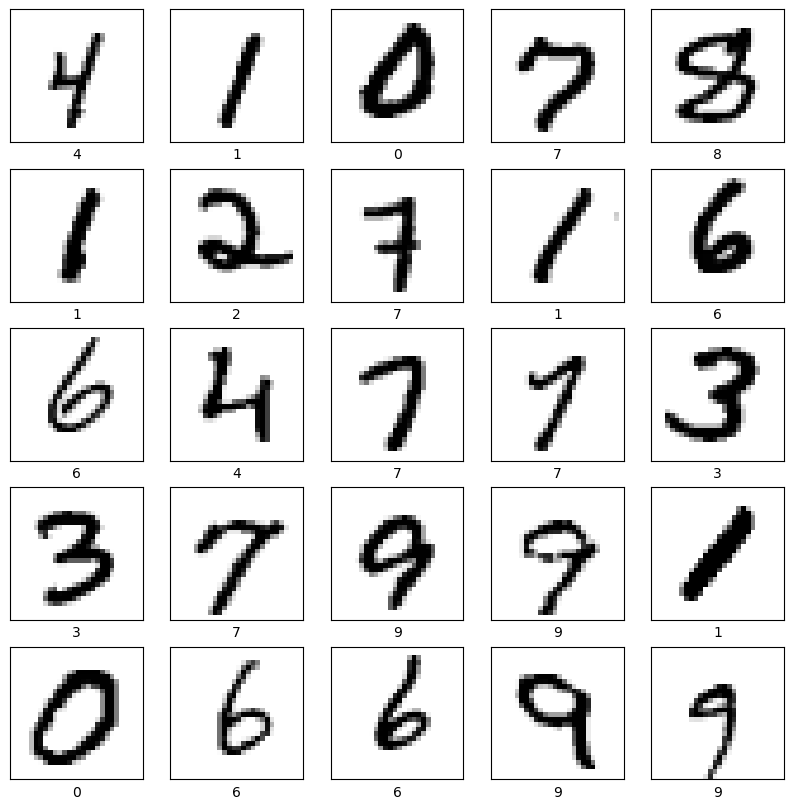

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))

for i, (image, label) in enumerate(training_data.take(25)):
    image = image.numpy().reshape((28,28))
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image, cmap=plt.cm.binary)
    plt.xlabel(classes[label])

plt.show()  

In [4]:
# Create the model (a dense model without convolutional layers yet)
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),  # 1 = grayscale
    tf.keras.layers.Dense(units=50, activation='relu'),
    tf.keras.layers.Dense(units=50, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Compile the model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)


In [5]:
# Number of training and test data (60k and 10k)
num_training_data = metadata.splits["train"].num_examples
num_test_data = metadata.splits["test"].num_examples

# Batch processing
BATCH_SIZE = 32

# Shuffle and repeat ensure that the data is randomly mixed
# to prevent the training from learning things in order
training_data = training_data.repeat().shuffle(num_training_data).batch(BATCH_SIZE)
test_data = test_data.batch(BATCH_SIZE)


In [6]:
# Perform the training
import math

# history = model.fit(
#     training_data,
#     epochs=60,
#     steps_per_epoch=math.ceil(num_training_data/BATCH_SIZE)
# )
# model.save('digit_non_CNN.h5')

In [7]:
from tensorflow.keras.models import load_model

model_non_cnn = load_model('digit_non_CNN.h5')

In [8]:
loss, accuracy = model_non_cnn.evaluate(test_data)
loss, accuracy

313/313 [==============================] - 2s 1ms/step - loss: 0.2456 - accuracy: 0.9727


(0.2456245869398117, 0.9726999998092651)

In [9]:
def classify_model_non_cnn(image):
    resized_image = image.resize((28, 28))
    # Convert the image to grayscale
    grayscale_image = resized_image.convert("L")
    # Convert the image to a NumPy array
    image_array = np.array(grayscale_image)

    normalized_image = 1 - image_array / 255.0
    reshaped_image = np.reshape(normalized_image, (1, 28, 28))
    reshaped_image = reshaped_image.astype(np.float32)

    predictions = model_non_cnn.predict(reshaped_image)

    # Get the predicted class index
    predicted_class = np.argmax(predictions)
    return predicted_class

In [10]:
from PIL import ImageTk, Image, ImageDraw
import PIL
from tkinter import *

def paint_and_model():

    width = 200  # canvas width
    height = 200 # canvas height
    center = height//2
    white = (255, 255, 255) # canvas back

    def paint(event):
        x1, y1 = (event.x - 1), (event.y - 1)
        x2, y2 = (event.x + 1), (event.y + 1)
        canvas.create_oval(x1, y1, x2, y2, fill="black",width=15)
        draw.line([x1, y1, x2, y2],fill="black",width=15)

    master = Tk()

    def close_window():
        master.destroy()
        
    def clear_window():
        canvas.delete("all")
        output_image.paste((255, 255, 255), (0, 0, width, height))        
    
    def do_classify():
        non_cnn_class = classify_model_non_cnn(output_image)
        classification_label.config(text=f"NonCNN:{non_cnn_class}")


    # create a tkinter canvas to draw on
    canvas = Canvas(master, width=width, height=height, bg='white')
    canvas.pack()

    # create an empty PIL image and draw object to draw on
    output_image = PIL.Image.new("RGB", (width, height), white)
    draw = ImageDraw.Draw(output_image)
    canvas.pack(expand=YES, fill=BOTH)
    canvas.bind("<B1-Motion>", paint)
    
    classification_label = Label(master, text="", font=("Courier Bold", 15))
    classification_label.pack()

    b1=Button(text="classify",command=do_classify)
    b1.pack(side=LEFT)
    
    button=Button(text="clear",command=clear_window)
    button.pack(side=LEFT)
        
    button=Button(text="close",command=close_window)
    button.pack(side=LEFT)
    
    master.mainloop()
    
paint_and_model()

1/1 [==============================] - 0s 12ms/step


## Recognizing digits with CNN

In [11]:
training_data = training.map(normalize)
test_data = testing.map(normalize)

# Cache the data (use memory instead of disk for faster training)
training_data = training_data.cache()
test_data = test_data.cache()

In [ ]:
# Create the model (utilizing convolutional and pooling layers)
# It consists of 1 convolutional layer with 32 filters and another with 64 filters. It also has 2 pooling layers.
# Finally, a dense layer with 100 neurons.
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), input_shape=(28,28,1), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),  # 2x2 is the matrix size

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),  # 2x2 is the matrix size

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=100, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Compile the model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [12]:
# Batch processing
BATCH_SIZE = 16

# Shuffle and repeat ensure that the data is randomly mixed
# to prevent the training from learning things in order
training_data = training_data.repeat().shuffle(num_training_data).batch(BATCH_SIZE)
test_data = test_data.batch(BATCH_SIZE)

# history = model.fit(
#     training_data,
#     epochs=60,
#     steps_per_epoch=math.ceil(num_training_data/BATCH_SIZE)
# )
# model.save('digit_CNN.h5')

del model
model_cnn = load_model('digit_CNN.h5')

In [13]:
loss, accuracy = model_cnn.evaluate(test_data)
loss, accuracy

625/625 [==============================] - 2s 1ms/step - loss: 0.1780 - accuracy: 0.9910


(0.1779548078775406, 0.9909999966621399)

In [14]:
def classify_model_cnn(image):
    resized_image = image.resize((28, 28))

    # Convert the image to grayscale
    grayscale_image = resized_image.convert("L")

    # Convert the image to a NumPy array
    image_array = np.array(grayscale_image)

    normalized_image = image_array / 255.0
    reshaped_image = np.reshape(normalized_image, (1, 28, 28, 1))
#     reshaped_image = reshaped_image.astype(np.float32)
    predictions = model_cnn.predict(1 - reshaped_image)

    # Get the predicted class index
    predicted_class_index = np.argmax(predictions)
    predict_label = classes[predicted_class_index]
    return predict_label

In [15]:
from PIL import ImageTk, Image, ImageDraw
import PIL
from tkinter import *

def paint_and_model():

    width = 200  # canvas width
    height = 200 # canvas height
    center = height//2
    white = (255, 255, 255) # canvas back

    def paint(event):
        x1, y1 = (event.x - 1), (event.y - 1)
        x2, y2 = (event.x + 1), (event.y + 1)
        canvas.create_oval(x1, y1, x2, y2, fill="black",width=15)
        draw.line([x1, y1, x2, y2],fill="black",width=15)

    master = Tk()

    def close_window():
        master.destroy()
        
    def clear_window():
        canvas.delete("all")
        output_image.paste((255, 255, 255), (0, 0, width, height))        
    
    def do_classify():
        cnn_class = classify_model_cnn(output_image)
        non_cnn_class = classify_model_non_cnn(output_image)
        classification_label.config(text=f"NonCNN:{non_cnn_class}, CNN:{cnn_class}")


    # create a tkinter canvas to draw on
    canvas = Canvas(master, width=width, height=height, bg='white')
    canvas.pack()

    # create an empty PIL image and draw object to draw on
    output_image = PIL.Image.new("RGB", (width, height), white)
    draw = ImageDraw.Draw(output_image)
    canvas.pack(expand=YES, fill=BOTH)
    canvas.bind("<B1-Motion>", paint)
    
    classification_label = Label(master, text="", font=("Courier Bold", 15))
    classification_label.pack()

    b1=Button(text="classify",command=do_classify)
    b1.pack(side=LEFT)
    
    button=Button(text="clear",command=clear_window)
    button.pack(side=LEFT)
        
    button=Button(text="close",command=close_window)
    button.pack(side=LEFT)
    
    master.mainloop()
    
paint_and_model()

1/1 [==============================] - 0s 12ms/step


**Note:** Although the accuracy on the testing set is higher, it is not clear that the visual results are better.

Lets try two techniques to improve the results, data augmentation and dropout

## Data Augmentation

In [ ]:
training_data = training.map(normalize)
test_data = testing.map(normalize)

# Cache the data (use memory instead of disk for faster training)
training_data = training_data.cache()
test_data = test_data.cache()

In [ ]:
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
    layers.RandomRotation(0.2),
    layers.RandomZoom((-0.1, 0.1)),
    layers.RandomTranslation((-0.1, 0.1), (-0.1, 0.1))
])


In [ ]:
# Number of training and test data (60k and 10k)
num_training_data = metadata.splits["train"].num_examples
num_test_data = metadata.splits["test"].num_examples

# Batch processing
BATCH_SIZE = 32

# Shuffle and repeat ensure that the data is randomly mixed
# to prevent the training from learning things in order
training_data = training_data.repeat().shuffle(num_training_data).batch(BATCH_SIZE)
test_data = test_data.batch(BATCH_SIZE)

model = tf.keras.Sequential([
    data_augmentation,
    
    tf.keras.layers.Conv2D(32, (3,3), input_shape=(28,28,1), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),  # 2x2 is the matrix size

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),  # 2x2 is the matrix size

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=100, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Compile the model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

# history = model.fit(
#     training_data,
#     epochs=10,
#     steps_per_epoch=math.ceil(num_training_data/BATCH_SIZE)
# )
# model.save('digit_CNN_DA.h5')

model_cnn_da = load_model('digit_CNN_DA.h5')

In [ ]:
loss, accuracy = model_cnn_da.evaluate(test_data)
loss, accuracy

In [ ]:
def classify_model_cnn_da(image):
    resized_image = image.resize((28, 28))

    # Convert the image to grayscale
    grayscale_image = resized_image.convert("L")

    # Convert the image to a NumPy array
    image_array = np.array(grayscale_image)

    normalized_image = image_array / 255.0
    reshaped_image = np.reshape(normalized_image, (1, 28, 28, 1))
#     reshaped_image = reshaped_image.astype(np.float32)
    predictions = model_cnn_da.predict(1 - reshaped_image)

    # Get the predicted class index
    predicted_class_index = np.argmax(predictions)
    predict_label = classes[predicted_class_index]
    return predict_label

In [ ]:
from PIL import ImageTk, Image, ImageDraw
import PIL
from tkinter import *

def paint_and_model():

    width = 200  # canvas width
    height = 200 # canvas height
    center = height//2
    white = (255, 255, 255) # canvas back

    def paint(event):
        x1, y1 = (event.x - 1), (event.y - 1)
        x2, y2 = (event.x + 1), (event.y + 1)
        canvas.create_oval(x1, y1, x2, y2, fill="black",width=15)
        draw.line([x1, y1, x2, y2],fill="black",width=15)

    master = Tk()

    def close_window():
        master.destroy()
        
    def clear_window():
        canvas.delete("all")
        output_image.paste((255, 255, 255), (0, 0, width, height))        
    
    def do_classify():
        cnn_class = classify_model_cnn(output_image)
        non_cnn_class = classify_model_non_cnn(output_image)
        cnn_class_da = classify_model_cnn_da(output_image)
        classification_label.config(text=f"NonCNN:{non_cnn_class}, CNN:{cnn_class}, CNNDA:{cnn_class_da}")


    # create a tkinter canvas to draw on
    canvas = Canvas(master, width=width, height=height, bg='white')
    canvas.pack()

    # create an empty PIL image and draw object to draw on
    output_image = PIL.Image.new("RGB", (width, height), white)
    draw = ImageDraw.Draw(output_image)
    canvas.pack(expand=YES, fill=BOTH)
    canvas.bind("<B1-Motion>", paint)
    
    classification_label = Label(master, text="", font=("Courier Bold", 15))
    classification_label.pack()

    b1=Button(text="classify",command=do_classify)
    b1.pack(side=LEFT)
    
    button=Button(text="clear",command=clear_window)
    button.pack(side=LEFT)
        
    button=Button(text="close",command=close_window)
    button.pack(side=LEFT)
    
    master.mainloop()
    
paint_and_model()

## Dropout

Dropout is a popular regularization technique used in deep learning models, particularly in neural networks.
- It helps prevent overfitting
- Randomly "drop out" (i.e., set to zero) a fraction of the neurons or input units during training.
- By doing so, dropout forces the network to learn more robust and independent representations because no single neuron can rely heavily on any other specific neuron. 
- This prevents the network from relying too much on particular features or correlations present only in the training data.

In [ ]:
training_data = training.map(normalize)
test_data = testing.map(normalize)

# Cache the data (use memory instead of disk for faster training)
training_data = training_data.cache()
test_data = test_data.cache()

In [ ]:
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
    layers.RandomRotation(0.2),
    layers.RandomZoom((-0.1, 0.1)),
    layers.RandomTranslation((-0.1, 0.1), (-0.1, 0.1))
])


In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="tensorflow")

# Number of training and test data (60k and 10k)
num_training_data = metadata.splits["train"].num_examples
num_test_data = metadata.splits["test"].num_examples

# Batch processing
BATCH_SIZE = 32

# Shuffle and repeat ensure that the data is randomly mixed
# to prevent the training from learning things in order
training_data = training_data.repeat().shuffle(num_training_data).batch(BATCH_SIZE)
test_data = test_data.batch(BATCH_SIZE)

model = tf.keras.Sequential([
    data_augmentation,
    
    tf.keras.layers.Conv2D(32, (3,3), input_shape=(28,28,1), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),  # 2x2 is the matrix size

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),  # 2x2 is the matrix size
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=100, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Compile the model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

# history = model.fit(
#     training_data,
#     epochs=10,
#     steps_per_epoch=math.ceil(num_training_data/BATCH_SIZE)
# )
# model.save('digit_CNN_DA_Drop.h5')

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="tensorflow")

model_cnn_da_drop = load_model('digit_CNN_DA_Drop.h5')

loss, accuracy = model_cnn_da_drop.evaluate(test_data)
loss, accuracy

In [ ]:
def classify_model_cnn_da_drop(image):
    resized_image = image.resize((28, 28))
    # Convert the image to grayscale
    grayscale_image = resized_image.convert("L")

    # Convert the image to a NumPy array
    image_array = np.array(grayscale_image)

    normalized_image = image_array / 255.0
    reshaped_image = np.reshape(normalized_image, (1, 28, 28, 1))
#     reshaped_image = reshaped_image.astype(np.float32)
    predictions = model_cnn_da_drop.predict(1 - reshaped_image)

    # Get the predicted class index
    predicted_class_index = np.argmax(predictions)
    predict_label = classes[predicted_class_index]
    return predict_label

In [ ]:
from PIL import ImageTk, Image, ImageDraw
import PIL
from tkinter import *

def paint_and_model():

    width = 200  # canvas width
    height = 200 # canvas height
    center = height//2
    white = (255, 255, 255) # canvas back

    def paint(event):
        x1, y1 = (event.x - 1), (event.y - 1)
        x2, y2 = (event.x + 1), (event.y + 1)
        canvas.create_oval(x1, y1, x2, y2, fill="black",width=15)
        draw.line([x1, y1, x2, y2],fill="black",width=15)

    master = Tk()

    def close_window():
        master.destroy()
        
    def clear_window():
        canvas.delete("all")
        output_image.paste((255, 255, 255), (0, 0, width, height))        
    
    def do_classify():
        cnn_class = classify_model_cnn(output_image)
        non_cnn_class = classify_model_non_cnn(output_image)
        cnn_class_da = classify_model_cnn_da(output_image)
        cnn_class_da_drop = classify_model_cnn_da_drop(output_image)
        classification_label.config(text=f"NonCNN:{non_cnn_class},CNN:{cnn_class},DA:{cnn_class_da},Drop:{cnn_class_da_drop}")


    # create a tkinter canvas to draw on
    canvas = Canvas(master, width=width, height=height, bg='white')
    canvas.pack()

    # create an empty PIL image and draw object to draw on
    output_image = PIL.Image.new("RGB", (width, height), white)
    draw = ImageDraw.Draw(output_image)
    canvas.pack(expand=YES, fill=BOTH)
    canvas.bind("<B1-Motion>", paint)
    
    classification_label = Label(master, text="", font=("Courier Bold", 15))
    classification_label.pack()

    b1=Button(text="classify",command=do_classify)
    b1.pack(side=LEFT)
    
    button=Button(text="clear",command=clear_window)
    button.pack(side=LEFT)
        
    button=Button(text="close",command=close_window)
    button.pack(side=LEFT)
    
    master.mainloop()
    
paint_and_model()